In [ ]:
pip install graphviz

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 


In [2]:
def f(x):
    return 3*x**2 -4*x+5

In [3]:
f(3.0)

20.0

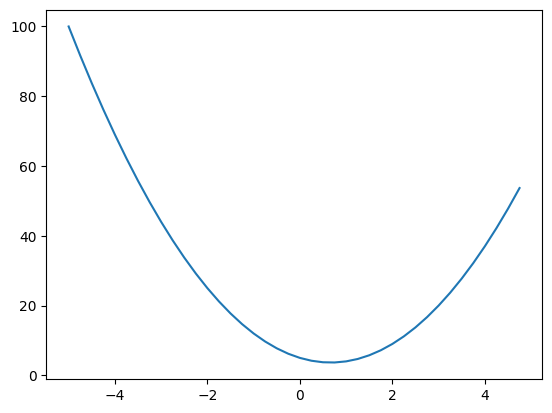

In [4]:
xs = np.arange(-5, 5, 0.25)
ys= f(xs)
plt.plot(xs, ys)

In [5]:
#h-Regel für das Ableiten 
h = 0.00000001
x = 2/3
(f(x+h)- f(x))/h

0.0

In [6]:
#more complex example 
a= 2.0
b= -3.0
c= 10.0
d= a*b +c
d

4.0

In [7]:
h= 0.0001
#inputs
a= 2.0
b= -3.0
c= 10.0
d1= a*b +c
a+= h
d2= a*b +c
print('d1', d1)
print('d2', d2)
print('slope',(d2-d1)/h )

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [10]:
class Value:
    # constructor
    def __init__(self, data, _children=(), _op='', label=''):
        self.data= data
        self._prev = set(_children)
        self.grad = 0.0
        self._op= _op
        self.label=label
        # backpropagation
        self._backward = lambda : None
        
    # pritty print wrapper function
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # overwrite add
    def __add__(self, other):
        # cast incase we want to do something like Value(data=1) +1 
        other = other if isinstance(other, Value) else Value(other)
        out= Value(self.data + other.data, (self, other), '+')
        # backpropagation
        def _backward():
                self.grad += 1.0 *out.grad
                other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    # fancy way to implement division, more general 
    def __truediv__(self, other): # self / other
        return self * other**-1

    # negation
    def __neg__(self): # -self
        return self * -1
    
    # substitution 
    def __sub__(self, other): # self - other
        return self + (-other)

    # reverse add fallback, same as for multiplication 
    def __radd__(self, other): # other + self
        return self + other
    
     # overwrite mul
    def __mul__(self, other):
        # cast incase we want to do something like Value(data=1) *1 
        other = other if isinstance(other, Value) else Value(other)
        out= Value(self.data * other.data, (self, other), '*')
         # backpropagation
        def _backward():
                self.grad += other.data *out.grad
                other.grad += self.data *out.grad
        out._backward = _backward
        return out
    
    # fallback function for the case  1 * Value(data=1), python checks rmul if mul cant handle the input 
    def __rmul__(self, other): # other * self
        return self * other
    
    # exponential operation  
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._backward = _backward
    
        return out
    
    # raise to the power operation 
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    # define tanh function 
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
    
        def _backward():
              self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    # backpropagation of the whole graph 
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        # set gradient for output node 
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
a=Value(data=2.0, label='a')
b=Value(data=-3.0, label='b')
c=Value(data=10.0, label='c')
e=a*b; e.label='e'
d=e+c; d.label='d'
f=Value(-2.0, label='f')
L=d*f;L.label='L'
L

Value(data=-8.0)

In [9]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [10]:
d._op

'+'

In [5]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

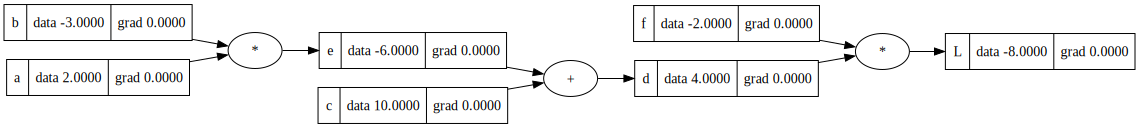

In [34]:
draw_dot(L)

In [35]:
# L=d*f
# dL/dd =? f
# dL/df =? d

L.grad=1.0
d.grad=-2.0
f.grad=4.0
e.grad=-2.0
c.grad=-2.0
a.grad= (-3.0 * 1.0 * -2.0)
b.grad= (2.0 * 1.0 * -2.0)

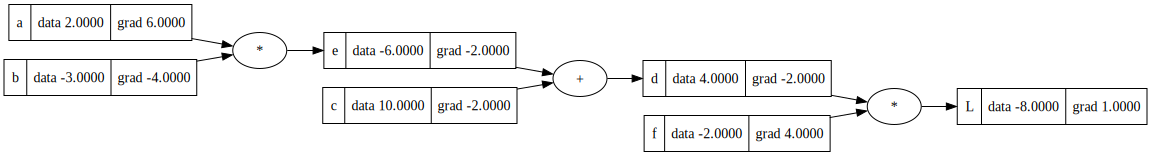

In [36]:
draw_dot(L)

In [ ]:
# Chain Rule !! Multiplication of the derivatives
#dL/dc = ? dL/dd *dd/dc
#dL/de = ? dL/dd *dd/de

Überlegung
# dd/dc = ? 1.0   (einfach c abgeleitet nach c ergibt 1)
# d=e +c 
# dd/de = ? 1.0 (ebenso, das ist immer so für lokale Summen)
# (das lokale Summen immer grad= 1.0 besitzen leitet der Plus Knoten immer den nächten Graditen einfach weiter ein Layer, wir multiplizieren 
# einfach mit 1, daher ist im Beispiel grad(e,c) = -2.0 )

In [ ]:
# Chain Rule für a und b 
# dL/da = dL/dd *dd/dc *de/da
# dL/db = dL/dd *dd/dc *de/db
# (bei Multiplikation haben wir schon gesehen wie es geht bei dL/dd, vertauschen)
# de/da = ? b 
# e = a*b
# de/db = ? a 

In [32]:
def lol():
    h = 0.0001
    a=Value(data=2.0, label='a')
    b=Value(data=-3.0, label='b')
    c=Value(data=10.0, label='c')
    e=a*b; e.label='e'
    d=e+c; d.label='d'
    f=Value(-2.0, label='f')
    L1=d*f;L.label='L'
    L1= L1.data
    
    a=Value(data=2.0, label='a')
    b=Value(data=-3.0, label='b')
    c=Value(data=10.0, label='c')
    e=a*b; e.label='e'
    d=e+c; d.label='d'
    d.data += h
    f=Value(-2.0, label='f')
    L2=d*f;L.label='L'
    L2= L2.data
    print((L2-L1)/h)
lol()

-1.9999999999953388


In [37]:
# First Epoch, Output sollte sich jetzt verändern 
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

#run forward path again 
e= a*b
d= e+c
L= d*f
print(L.data)

-7.286496


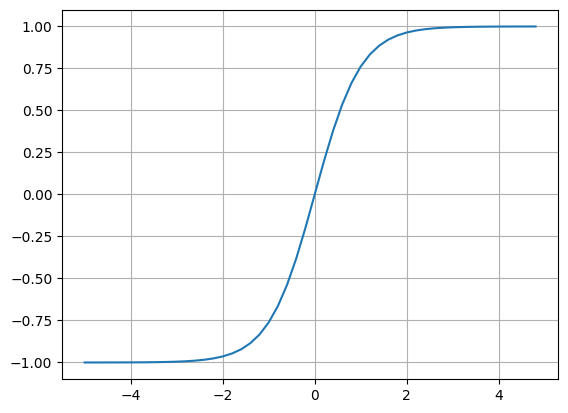

In [39]:
# tanh Function 
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

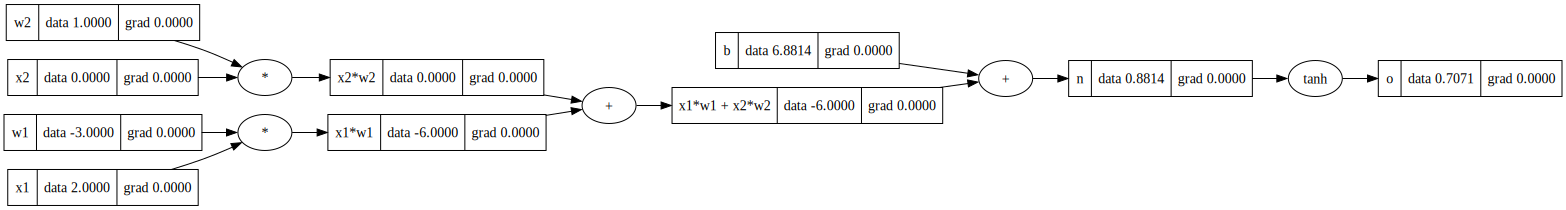

In [47]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# Activation Function 
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [55]:
# calculate gradients (Backpropagation)
# base case "o" = ? 1.0 immer so, nochmal verstehen!!

# do/dn = ? 1-tanh(n)**2
# o = tanh(n) 

# o in Gleichung einsetzen 
# do/dn = ? 1-o**2
# do/dn = ?  1-o.data**2  =0.5

# "+" Node bedeutet, der Gradient wird vom Child einfach zum Parent weitergegeben
# daher ist b und "x1*w1+x2*w2" = 0.5

# ebenso für x2w2 und x1w1= 0.5 

#inputs 
# x2.grad = w2.data * w2x2.grad
# w2.grad = x2.data * w2x2.grad

# w1.grad = x1.data * x1w1.grad
# x1.grad = w1.data * x1w1.grad

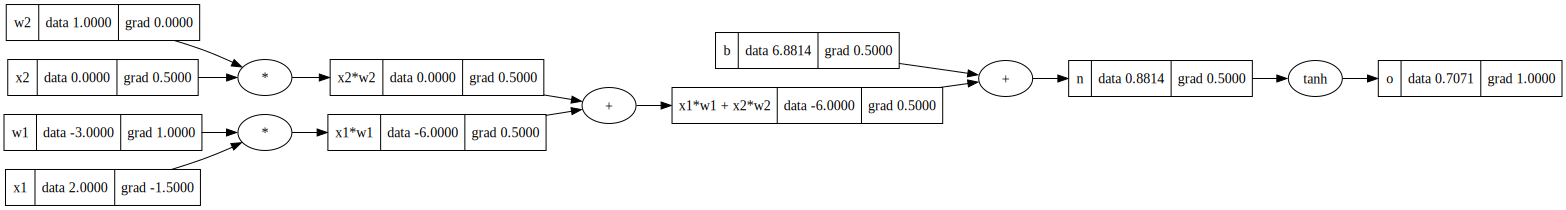

In [56]:
o.grad= 1.0
n.grad= 0.5
x1w1x2w2.grad = 0.5
b.grad= 0.5
x2w2.grad= 0.5
x1w1.grad= 0.5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad
draw_dot(o)

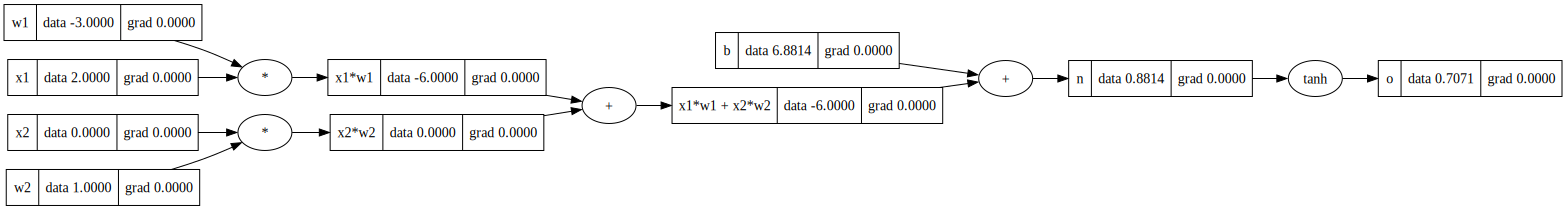

In [69]:
# automatic backpropagation example 

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# Activation Function 
o = n.tanh(); o.label = 'o'
draw_dot(o)

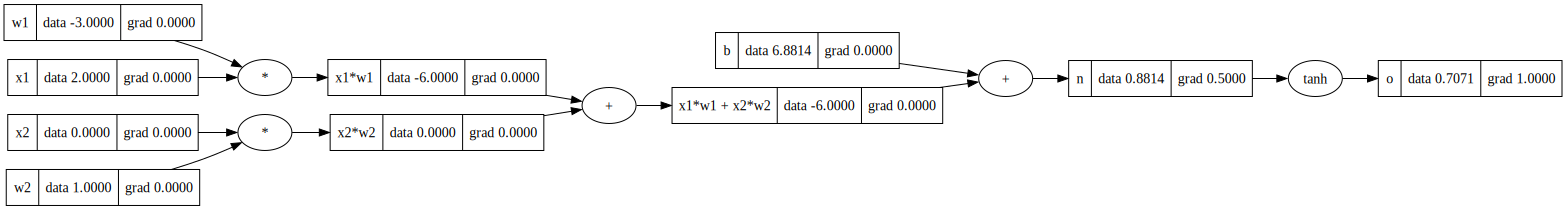

In [70]:
o.grad = 1.0 
o._backward()

draw_dot(o)

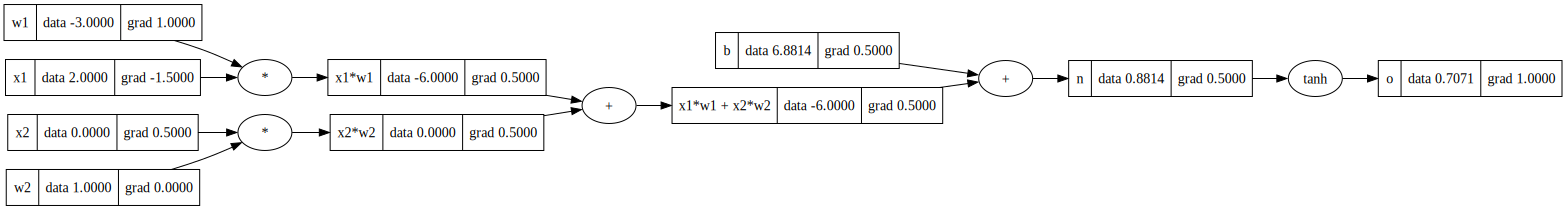

In [74]:
#n._backward()
#x1w1x2w2._backward()
#x1w1._backward()
#x2w2._backward()
draw_dot(o)

In [78]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

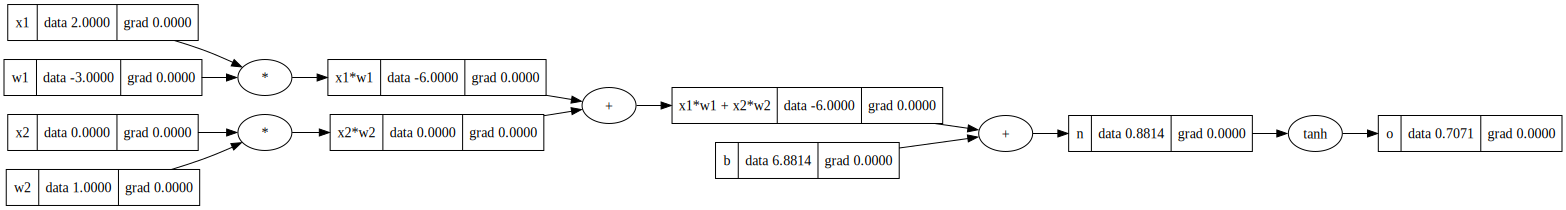

In [94]:
# automatic backpropagation example 

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# Activation Function 
o = n.tanh(); o.label = 'o'
draw_dot(o)

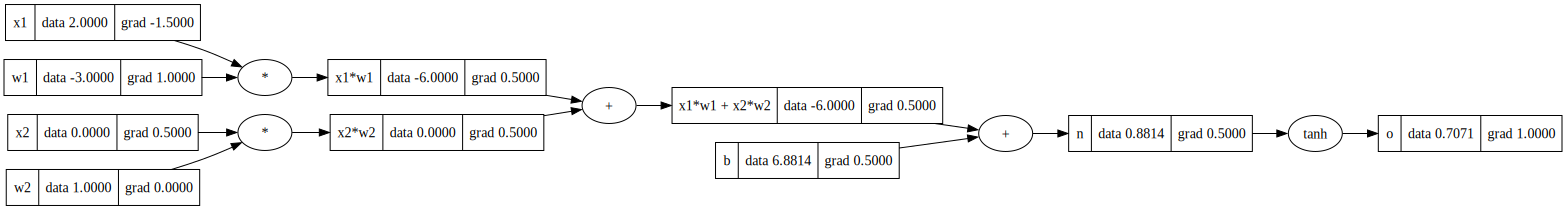

In [95]:
# automatic backpropagration for the whole graph with the help of toplogical sort :) 
o.backward()
    
draw_dot(o)

In [ ]:
#### it works!!! 

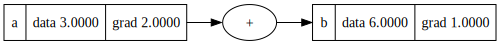

In [102]:
# Bug with the "+" operator, gradient was wrong 
# db/da = ? 2 but it's 1.0 at the moment 
# b= a+a
# b= 2a
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

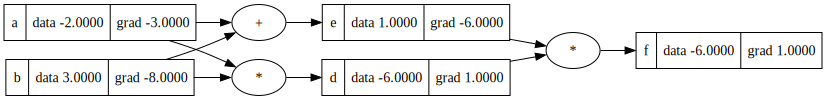

In [103]:
# same bug other example 
# solution -> we have to accumulate the gradients 
# def _backward():
               # self.grad += 1.0 *out.grad
               # other.grad += 1.0 * out.grad

a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

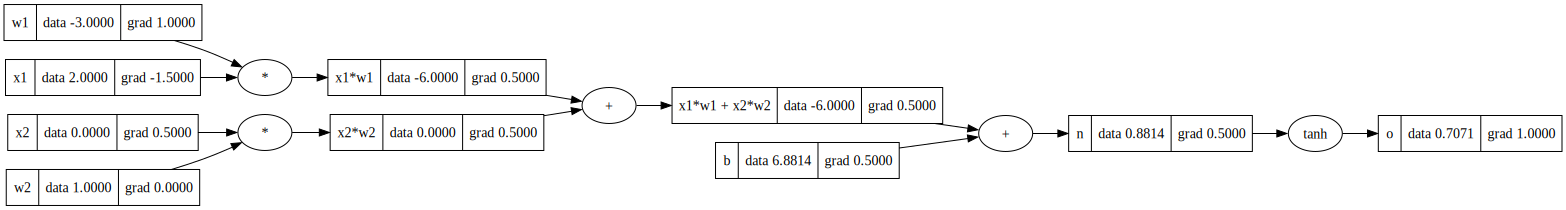

In [121]:
# automatic backpropagation example 
# tanh advanced 

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# Activation Function 
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

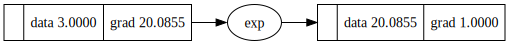

In [117]:
# exponential operation with backpropagation 
a = Value(3)
b = a.exp()
b.backward()
draw_dot(b)

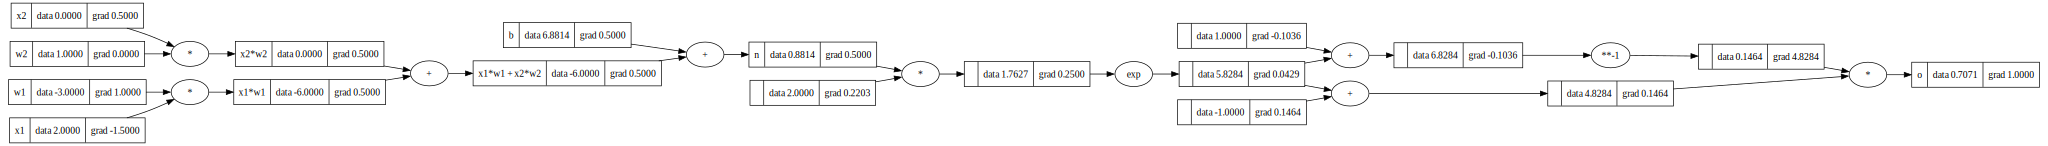

In [122]:
# brake-up tanh function 

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [124]:
import torch

In [125]:
# same stuf with pytorch instead of micrograd 
# we need to cast to double becaus python uses double but pytorch uses only float32 

# those are tensors with only a single element, like a matrix with a single cell, but you could as well input whole matrix structers as an tensor 3x3, 9x27 ... 
# we need to define that we need gradients!! becausae it assumes those are all leaf nodes 
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

# prints the forward path 0.70.. 
print(o.data.item())
o.backward()

# prints the backward paths  
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [20]:
import random
import math

In [21]:
class Neuron:
    # constructor 
    # nin: number of inputs (weights)
    def __init__(self, nin):
        # initialize weights (w) and bias (b) with random numbers between [-1,1] 
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
  
    def __call__(self, x):
        # w * x + b
        # x = [2.0, 3.0]
        # initialize neuron with 2 dimensions 
        # n = Neuron(2)
        # set neuron to x, python will use the __call__ function internaly 
        #n(x)
        
        # this is a dot product, we multiply the inputs times the weights and create a sum of those pairs, futhermore we add the bias 
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        
        # after this we call the activation function, like sigmoid or in this case tanh 
        out = act.tanh()
        return out
  
    # a function to collect all the parameters that we can use to manipulate each epoch with respect to the gradient 
    # weights + bias
    def parameters(self):
        return self.w + [self.b]

class Layer:
    # nout: number of outputs neurons per layer, nin: dimentionality od the neurons (number of inputs of the neurons)
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
  
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
  
    # a function to collect all the parameters that we can use to manipulate each epoch with respect to the gradient 
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

# multi-layer perceptron, just x layers with y neurons  with k inputs (weights)
class MLP:
    # nin: number of inputs, nnouts: list of layers with x amout of neurons [2,4,3] would be a layer with 2 neurons, layer with 4 neurons, layer with 3 neurons 
    def __init__(self, nin, nouts):
        # put nin in a list and conjugate with the list nouts, resulting in a list [6] + [3,4] = [6,3,4] 
        sz = [nin] + nouts
        # layer 1 = Layer(3,4), layer 2 = Layer(4,4) ...
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    # a function to collect all the parameters that we can use to manipulate each epoch with respect to the gradient 
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [22]:
 # w * x + b
x = [2.0, 3.0, -3.0]
# MLP with 3 inputs and 2 layers with 4 neurons and one layer with 1 neuron 
n = MLP(3, [4, 4, 1])
# print forward path of the MLP
n(x)


Value(data=0.5878701874813083)

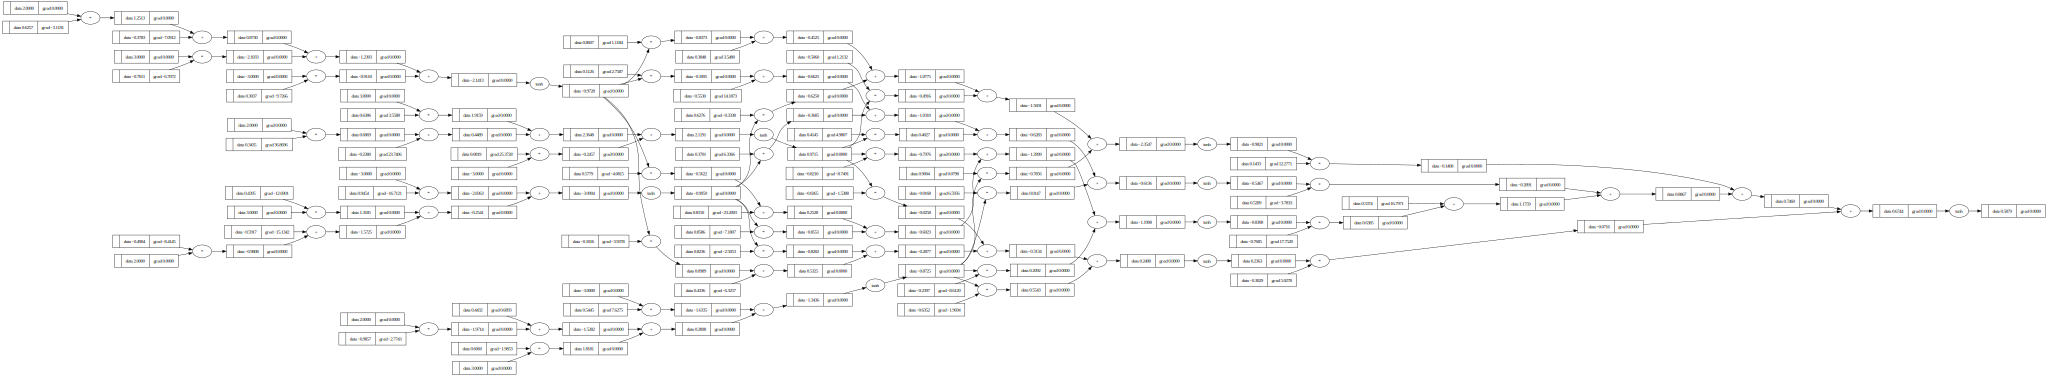

In [29]:
draw_dot(n(x))

In [41]:
# let's create a tiny dataset 
# desired target for [2.0, 3.0, -1.0] -> 1.0 .... 
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
# predicted outputs for the four inputs
# n is our MLP from above 
ypred = [n(x) for x in xs]
ypred

[Value(data=0.6529641232609475),
 Value(data=-0.30385054293606545),
 Value(data=0.17609387794611245),
 Value(data=0.5018906631645491)]

In [43]:
# we need to implement Mean squared error to first calculate error (ypred- ydesired)^2 and second do backproagation 
# we need to accumulate all the loss for each epoch, sum of losses of the four inputs 
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=2.236367687499432)

In [45]:
print("hey")

hey


In [46]:
loss.backward()

In [53]:
n.layers[0].neurons[0].w[0].grad

-3.2722801814480804

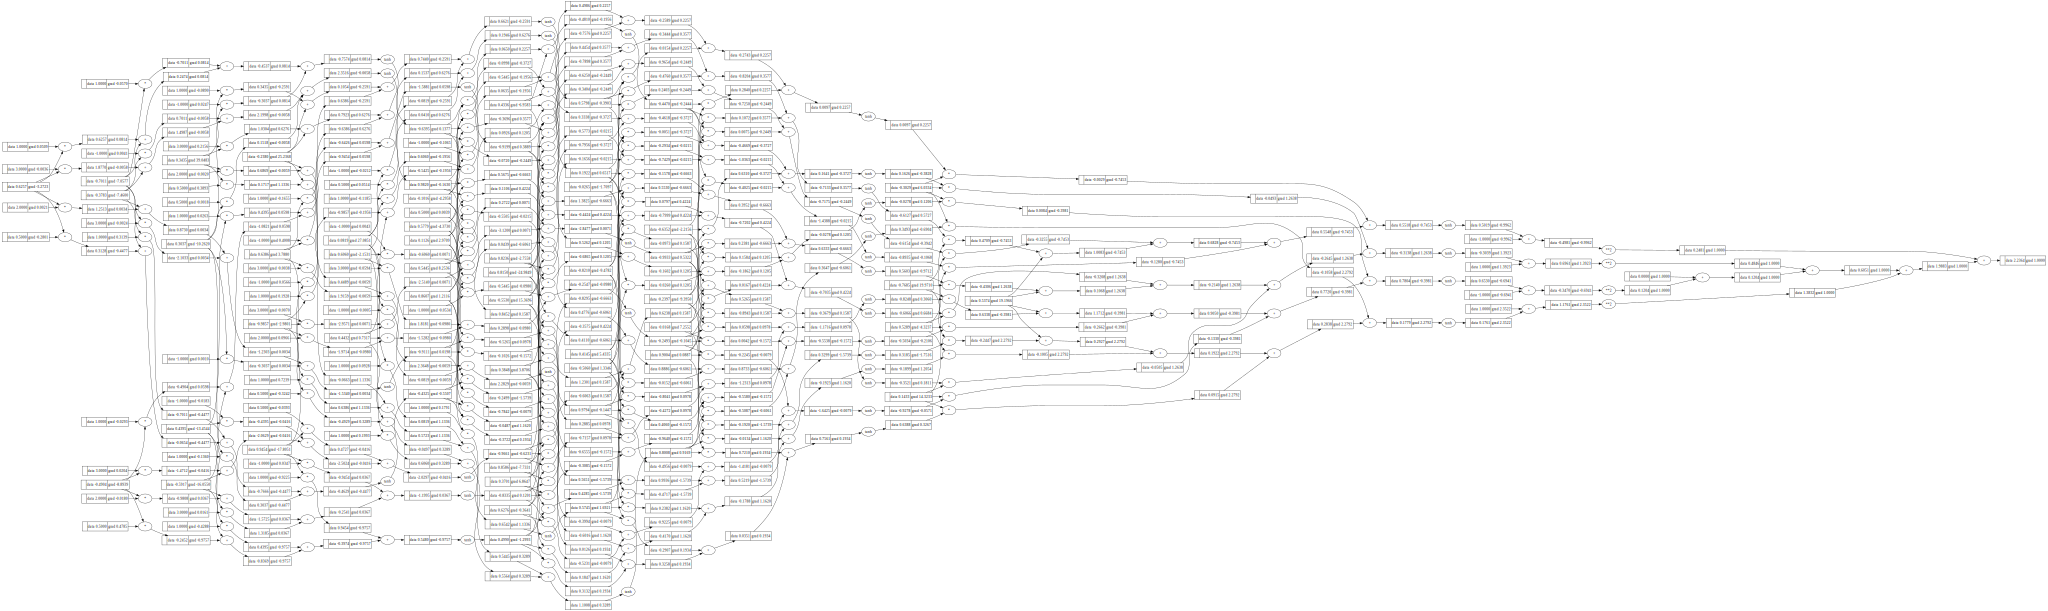

In [54]:
draw_dot(loss)

In [57]:
# n is still our MLP from above 
n.parameters()

[Value(data=0.625655768903407),
 Value(data=-0.7011131093928353),
 Value(data=0.303651001167593),
 Value(data=-0.378277275604443),
 Value(data=-0.4904043411864365),
 Value(data=0.4394875563502534),
 Value(data=0.9454362627801267),
 Value(data=-0.5917176763570537),
 Value(data=0.34345209219171235),
 Value(data=0.6386298865520688),
 Value(data=0.0819032252915124),
 Value(data=-0.23803226783646148),
 Value(data=-0.9857113835013993),
 Value(data=0.6060257392300974),
 Value(data=0.5444915353909654),
 Value(data=0.44318302412370336),
 Value(data=0.5779224075351377),
 Value(data=0.8586433716053441),
 Value(data=-0.8209933738591211),
 Value(data=-0.2397060542638152),
 Value(data=0.8149982421144917),
 Value(data=0.1125983599674909),
 Value(data=0.3700694719006765),
 Value(data=0.41452960818353923),
 Value(data=-0.016793173474749068),
 Value(data=-0.5529522626561301),
 Value(data=0.86070754801515),
 Value(data=0.6275975235710729),
 Value(data=-0.5060326612843866),
 Value(data=0.9003638988601976)

In [59]:
# show number of parameters ? 41 
len(n.parameters())

41

In [63]:
# manipulate the parameters with respect to their gradient and the step size 
print(n.layers[0].neurons[0].w[0].grad)
print(n.layers[0].neurons[0].w[0].data)

-3.2722801814480804
0.625655768903407


In [65]:
for p in n.parameters():
    p.data += -0.01 *p.grad

In [66]:
# manipulate the parameters with respect to their gradient and the step size 
print(n.layers[0].neurons[0].w[0].grad)
print(n.layers[0].neurons[0].w[0].data)


-3.2722801814480804
0.6583785707178879


In [69]:
# loss should be less y now 
#forward path 
ypred = [n(x) for x in xs]
ypred

[Value(data=0.48757980536350615),
 Value(data=-0.8022267769112575),
 Value(data=-0.7923452575968709),
 Value(data=0.17999332122972989)]

In [70]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=1.0172201489125707)

In [71]:
#yes!!!

In [72]:
# now we have to just itterate: forward path, backproppagation, update 

In [79]:
n = MLP(3, [4, 4, 1])

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets 

for k in range(100):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    # reset the gradients after each epoch
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update, 0.05 is the learning rate 
    for p in n.parameters():
        p.data += -0.05 *p.grad
    
    print(k, loss.data)
    

0 9.039743897402541
1 7.760292867634616
2 7.482741278408417
3 6.978399778517119
4 5.39811054520115
5 1.5468275740337847
6 0.4788526399438213
7 0.23290031804577938
8 0.1563944690104136
9 0.11743433096158765
10 0.09383797111036865
11 0.07803434108649589
12 0.06672233929815787
13 0.05823272736743004
14 0.051631024184975616
15 0.046353540525869805
16 0.042040213834419055
17 0.0384503672436192
18 0.03541707344883708
19 0.03282095299082194
20 0.030574394283426932
21 0.028611661829073168
22 0.026882480570348758
23 0.025347750819463333
24 0.023976612074231213
25 0.022744385351215646
26 0.021631102148339302
27 0.020620433911112082
28 0.019698900407765948
29 0.018855275833461985
30 0.01808013737484663
31 0.017365517933714825
32 0.016704636034810323
33 0.016091683636957378
34 0.015521657878005996
35 0.014990226504922603
36 0.01449361938270888
37 0.014028540376070188
38 0.013592095280368777
39 0.013181732495391415
40 0.012795193891159245
41 0.012430473881898323
42 0.01208578515335575
43 0.01175952

In [80]:
ypred

[Value(data=0.9604387593533376),
 Value(data=-0.9735184398483031),
 Value(data=-0.9709118041150407),
 Value(data=0.960665060959127)]